In [166]:
# imports
import astropy
import numpy as np
from astropy.io import fits, votable
from astropy.table import Table, Column
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import kdtree
from glob import glob
import sys
import argparse
from statistics import median, mean

In [132]:
# Command line args
#first_arg = sys.argv[1]
#second_arg = sys.argv[2]
#try:
#    third_arg = sys.argv[3]
#    fourth_arg = sys.argv[4]
#except:
#    third_arg = None
#    fourth_arg = None
# argparse
parser = argparse.ArgumentParser()
parser.add_argument("-q", "--query_type", choices=['zone', 'coords', 'bd', 'gal'], help="Type of function/query you want to run")
parser.add_argument("-f", "--fast", help="Limit query to objects over PM > 0.1 as/yr",
                    action="store_true")
parser.add_argument("-g", "--gaia", help="Match with gaia data",
                    action="store_true")
parser.add_argument("-z" ,"--zone", help="Zone number to query")
parser.add_argument("-t", "--tile", help="Tile name to query")
parser.add_argument("-v", "--vel", help="Minimum velocity of objects returned from query", default = 0.1)
parser.add_argument("-s", "--spread", help="Maximum spread model of objects returned from query", default = 0.006)
parser.add_argument("-n", "--numobs", help="Minimum number of observations of objects returned from query", default = 9)
parser.add_argument("-r", "--ra", help="RA to pass into coordinate query")
parser.add_argument("-d", "--dec", help="Dec to pass into coordinate query")
parser.add_argument("-o", "--outfile", help="Number on the output file")
args = parser.parse_args()


usage: ipykernel_launcher.py [-h] [-q {zone,coords,bd}] [-f] [-g] [-z ZONE]
                             [-t TILE] [-v VEL] [-s SPREAD] [-n NUMOBS]
                             [-r RA] [-d DEC]
ipykernel_launcher.py: error: unrecognized arguments: /Users/Suyog/Library/Jupyter/runtime/kernel-6689dfc5-2bdf-44ba-a8ea-bae551c857a2.json


SystemExit: 2

/Users/Suyog/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [162]:
# This class emulates a tuple, but contains a useful payload - for KDTree
class Node(object):
    def __init__(self, ra, dec, data, idx = 0):
        self.coords = (ra, dec)
        self.data = data
        self.idx = idx

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, i):
        return self.coords[i]
    
    def getdata(self):
        return self.data
    
    def get_index(self):
        return self.idx

    def __repr__(self):
        return 'Node({}, {}, {})'.format(self.coords[0], self.coords[1], self.data)

In [3]:
# path to zones file
zones = Table.read('zones.fits')

In [4]:
# src directories
in_dir = './'#/data3/garyb/tno/matcher/'
out_dir = './'#'./output/'

In [126]:
# 
def Query_PM(zone, tile, fast = False, vel = 0.1, spread_model = 0.006, n = 9, gaia = False):
    '''tilewise query given Zone number and tilename'''
    #find the zone folder
    path = in_dir + 'zone' + "{:0>3}".format(zone) + '/' + tile + '_proper_n.fits'
    #find the tile to query
    tile = Table.read(path) #some tile
    t = tile[np.where(tile['SPREAD_MODEL_WAVG'] < spread_model)]
    idx = []
    for i, row in enumerate(t):
        # cuts
        if (row['N'] < n) | (row['CHI2_RED'] > 3) | (row['MAG_AUTO_G'] > 24) | (row['MAG_AUTO_R'] > 23) | (row['VEL']/row['SIGMA_VEL'] < 5):
            continue
        elif fast:
            if row['VEL'] > vel:
                idx.append(i)
        else:
            idx.append(i)
    res = t[idx]
    if gaia:
        res = gaia_match(t[idx], zone)
    return res

In [6]:
# coordinate query
def Query_by_coords(RA, Dec, fast = False):
    ''' Query given RA and Dec for a point '''
    tgt = zones[np.where((zones['RACMAX'] > RA) & (zones['RACMIN'] < RA) & (zones['DECCMAX'] > Dec) & (zones['DECCMIN'] < Dec))]
    zone = tgt['ZONE']
    tile = tgt['TILE']
    blacklist = Table.read('blacklist.txt', format = 'ascii')
    results = []
    if len(tile) == 1:
        if tile[0] in blacklist['Tile']:
            pass
        else:
            results.append(Query_PM(zone[0], tile[0], fast))
    else:
        for i,t in enumerate(tile):
            if t in blacklist['Tile']:
                continue
            else:
                results.append(Query_PM(zone[i], t, fast))
    return results

In [64]:
def BD_match():
    ''' Function to match Aurelio's Brown dwarfs file to our data '''
    bd = Table.read('DES_Y3_known_BDs_with_motions.fits')
    vz_list = [29]#[3, 6, 7, 10, 11, 15, 16, 17, 29, 55]
    z_list = []
    tile_list = []
    r_list = []
    # get zone and tile for each processed BD candidate
    for row in bd:
        RA = row['RA']
        Dec = row['DEC']
        tgt = zones[np.where((zones['RACMAX'] > RA) & (zones['RACMIN'] < RA) & (zones['DECCMAX'] > Dec) & (zones['DECCMIN'] < Dec))]
        zone = tgt['ZONE']
        tile = tgt['TILE']
        if (len(zone) != 0):
            if zone[0] in vz_list:
                z_list.append(zone[0])
                tile_list.append(tile[0])
                r_list.append(row)
    out = Table(names=('COADD_OBJECT_ID', 'MU_RA_DES','MU_RA_DES_ERR','MU_DEC_DES','MU_DEC_DES_ERR', 'MU_RA_2MASS_WISE','MU_RA_2MASS_WISE_ERR', 'MU_DEC_2MASS_WISE', 'MU_DEC_2MASS_WISE_ERR'))
    for i, row in enumerate(r_list):
        t = get_zone(z_list[i], tile_list[i], row['COADD_OBJECT_ID'])
        r = t[np.where(t['COADD_OBJECT_ID'] == row['COADD_OBJECT_ID'])]
        if len(r) != 0:
            r = r[0]
            mura = row['2MASS-WISE-mu_alfa'].split(' ')[0]
            mura_err = row['2MASS-WISE-mu_alfa'].split(' ')[2]
            mudec = row['2MASS-WISE-mu_delta'].split(' ')[0]
            mudec_err = row['2MASS-WISE-mu_delta'].split(' ')[2]
            out.add_row((row['COADD_OBJECT_ID'], r['MU_RA'], r['MU_RA_ERR'], r['MU_DEC'], r['MU_DEC_ERR'], mura, mura_err, mudec, mudec_err))
    return out

In [164]:
def gaia_match(tile, zone):
    """ Matches the tile data to Gaia data using the Gaia KDTree provided """
    match = []
    # add columns
    col = Table.Column(data=[''*len(tile)], name = 'GAIA_MATCH', dtype='U50')
    tile['GAIA_MATCH'] = col
    col2 = Table.Column(data=[0]*len(tile), name = 'GAIA_MATCH_DIST', dtype='f8')
    tile['GAIA_MATCH_DIST'] = col2
    # get tree
    g_name = 'Gaia-Z' + "{:0>3}".format(zone) + '.csv'
    g = Table.read('./gaia/' + g_name)
    tree = get_kdtree(g)
    # match objects
    for i, j in enumerate(tile):
        tgt = Node(tile[i]['RA'], tile[i]['DEC'], '')
        tup = tree.search_nn(tgt)
        # 25 arcseconds - 0.00005
        # 10 arcseconds - 0.000008
        # 5 arcseconds - 0.0000019
        # 1 arcsecond - 7.7 x 10^-8
        #print(tup)
        if tup[1] < (7.7*10**-8):
            #print(tile['RA', 'DEC'][i])
            #print(tup)
            match.append(i)
            tile['GAIA_MATCH'][i] = tup[0].data.getdata()
            tile['GAIA_MATCH_DIST'][i] = tup[1]
            #sim_num.append(tup[0].data.get_index())
    return tile[match]

def get_kdtree(table):
    """ Calculates the KDTree from Gaia data. """
    nodes = []
    for i in range(len(table)):
        ra_deg = table['ra'][i]
        dec_deg = table['dec'][i]
        curr = Node(ra_deg, dec_deg, table['designation'][i])
        nodes.append(curr)
    tree = kdtree.create(nodes)
    return tree

In [131]:
if __name__ == "__main__":
    t = None
    if args.query_type == 'zone':
        t = Query_PM(args.zone, args.tile, fast = args.fast, vel = args.vel, spread_model = args.spread, n = args.numobs, gaia = args.gaia)
    elif args.query_type == 'coords':
        t = Query_by_coords(args.ra, args.dec, fast = args.fast)
    elif args.query_type == 'bd':
        t = BD_match()
    elif args.query_type == 'gal':
        t = Median_galaxy_PMs()
    outfile = "Query{}.fits".format(args.outfile)
    t.write(out_dir + outfile, format = 'fits')

NameError: name 'args' is not defined

In [282]:
def Median_galaxy_PMs():
    zones = [29, 55] #2, 6, 15
    out = Table(names=('ZONE', 'TILE', 'MEDIAN_GALAXY_MU_RA', 'MEDIAN_GALAXY_MU_DEC', 'GAIA-DES_MU_RA', 'GAIA-DES_MU_DEC', 'RA', 'DEC'), dtype=('i4','S30', 'f8', 'f8','f8','f8', 'f8', 'f8'))
    for zone in zones:
        path = in_dir + 'zone' + "{:0>3}".format(zone) + '/'
        filenames = glob(path + '*proper_n.fits')
        tiles = []
        list.sort(filenames)
        for name in filenames:
            tiles.append(Table.read(name))
        # Potentially galaxies?
        for i, tile in enumerate(tiles):
            dra, ddec = Gaia_PM_diff(zone, tile)
            mra, mdec = Galaxy_PM_tile(tile)
            out.add_row((zone, filenames[i], mra, mdec, dra, ddec, tile[0]['RA'], tile[0]['DEC']))
    return out

def Gaia_PM_diff(zone, tile):
    #gal = np.where(tile['SPREAD_MODEL_WAVG'] > 0.01)
    #galx = tile[gal]
    gal = tile[np.where(tile['SPREAD_MODEL_WAVG'] < 0.006)]
    idx = []
    for i, row in enumerate(gal):
        # cuts
        if (row['N'] < 9) | (row['CHI2_RED'] > 3) | (row['MAG_AUTO_G'] > 24) | (row['MAG_AUTO_R'] > 23) | (row['VEL']/row['SIGMA_VEL'] < 5):
            continue
        else:
            idx.append(i)
    gal_m = gaia_match(gal[idx], zone)
    # consider switching to gaia_match func
    # diff
    dpmra = []
    dpmdec = []
    for i, iden in enumerate(gal_m):
        g_id = iden['GAIA_MATCH']
        g_name = 'Gaia-Z' + "{:0>3}".format(zone) + '.csv'
        g = Table.read('./gaia/' + g_name)
        row = g[np.where(g['designation'] == g_id)]
        if g['pmra'].mask[np.where(g['designation'] == g_id)] == False:
            dpmra.append(row['pmra']/1000 - iden['MU_RA'])
            dpmdec.append(row['pmdec']/1000 - iden['MU_DEC'])
    dra = median(dpmra)
    ddec = median(dpmdec)
    return dra, ddec

def Galaxy_PM_tile(tile):
    gal = np.where(tile['SPREAD_MODEL_WAVG'] > 0.01)
    mra = median(tile[gal]['MU_RA'])
    mdec = median(tile[gal]['MU_DEC'])
    return mra, mdec

In [65]:
t = BD_match()
outfile = "Query{}.fits".format('001')
t.write(out_dir + outfile, format = 'fits', overwrite = True)

In [71]:
qr = Table.read('Query001.fits')

In [24]:
def get_zone(zone, tile,coadd_id):
    #find the zone folder
    path = in_dir + 'zone' + "{:0>3}".format(zone) + '/' + tile + '_proper_n.fits'
    #find the tile to query
    tile = Table.read(path) #some tile
    r = tile[np.where(tile['COADD_OBJECT_ID'] == coadd_id)]
    return r

In [72]:
qr

COADD_OBJECT_ID,MU_RA_DES,MU_RA_DES_ERR,MU_DEC_DES,MU_DEC_DES_ERR,MU_RA_2MASS_WISE,MU_RA_2MASS_WISE_ERR,MU_DEC_2MASS_WISE,MU_DEC_2MASS_WISE_ERR
float64,float64,float64,float64,float64,float64,float64,float64,float64
189071176.0,0.135031663755,2.33688340747e-06,-0.0260584322208,2.17515069244e-06,135.5,13.5,-16.8,17.3
190602828.0,-0.0332564641504,1.14711518115e-06,-0.0375023094173,2.0451521185e-06,-42.4,13.1,-30.2,16.1
197792469.0,0.12709725125,3.67836014409e-06,-0.0672276740341,3.62321796389e-06,112.5,49.3,-58.7,48.2
199485708.0,0.113924657993,1.35807145781e-06,0.052412620883,1.57814928242e-06,117.5,18.4,67.8,19.3
203462728.0,-0.0797450265975,1.34355720504e-06,0.135555015933,2.75444840744e-06,-71.6,8.6,145.6,7.9
205407029.0,0.117727530862,9.49389743476e-06,-0.0220776828945,9.15970505838e-06,-37.1,32.8,41.0,32.4
146734478.0,0.361048497306,2.50664177993e-05,-0.339720667398,1.92634414029e-05,407.3,11.7,-317.0,10.9
278584371.0,-0.166942764535,3.79917152463e-06,-0.167677694705,2.57337451668e-06,-128.2,26.2,-148.8,26.8
281880968.0,0.13452880008,8.46329722698e-06,0.0210002992572,8.605169047e-06,40.8,9.2,10.3,8.5


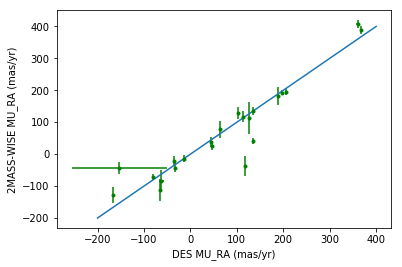

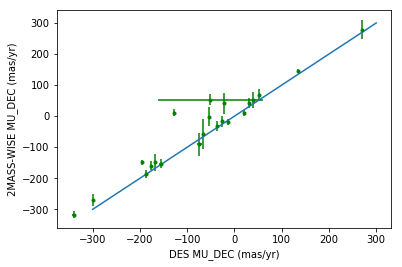

In [81]:
for i, row in enumerate(qr):
    plt.errorbar(row['MU_RA_DES']*1000, row['MU_RA_2MASS_WISE'], xerr = (np.sqrt(row['MU_RA_DES_ERR']))*1000, yerr=row['MU_RA_2MASS_WISE_ERR'], fmt = 'g.')
plt.plot([-200,400],[-200,400])
plt.xlabel('DES MU_RA (mas/yr)')
plt.ylabel('2MASS-WISE MU_RA (mas/yr)')
plt.show()
for i, row in enumerate(qr):
    plt.errorbar(row['MU_DEC_DES']*1000, row['MU_DEC_2MASS_WISE'], xerr = (np.sqrt(row['MU_DEC_DES_ERR']))*1000, yerr=row['MU_DEC_2MASS_WISE_ERR'], fmt = 'g.')
plt.plot([-300,300],[-300,300])
plt.xlabel('DES MU_DEC (mas/yr)')
plt.ylabel('2MASS-WISE MU_DEC (mas/yr)')
plt.show()

In [103]:
z = 186
print('Dec min:', min(zones[np.where(zones['ZONE'] == z)]['DECCMIN']))
print('Dec max:', max(zones[np.where(zones['ZONE'] == z)]['DECCMAX']))
print('RA min:', min(zones[np.where(zones['ZONE'] == z)]['RACMIN']))
print('RA max:', max(zones[np.where(zones['ZONE'] == z)]['RACMAX']))

Dec min: -57.457856
Dec max: -52.444361
RA min: 49.032145
RA max: 58.682923


In [30]:
bd = Table.read('DES_Y3_known_BDs_with_motions.fits')

In [86]:
"""
for row in bd:
    print('mura:',row['2MASS-WISE-mu_alfa'].split(' ')[0])
    print('mura_err:',row['2MASS-WISE-mu_alfa'].split(' ')[2])
    print('mudec', row['2MASS-WISE-mu_delta'].split(' ')[0])
    print('mudec_err', row['2MASS-WISE-mu_delta'].split(' ')[2])
"""
bd[np.where(bd['COADD_OBJECT_ID'] == 205407029.0)]

PSF_MAG_ERR_G,PSF_MAG_ERR_R,PSF_MAG_ERR_I,PSF_MAG_ERR_Z,PSF_MAG_G,PSF_MAG_R,PSF_MAG_I,PSF_MAG_Z,EXT_NGMIX,COADD_OBJECT_ID,RA,DEC,MAG_AUTO_Y,MAGERR_AUTO_Y,SPT_NUM,DELTA_MAG_Y4_G,DELTA_MAG_Y4_R,DELTA_MAG_Y4_I,DELTA_MAG_Y4_Z,DELTA_MAG_Y4_Y,Name,SpT_OPT,SpT_NIR,D_Trig (pc),2MASS-WISE-mu_alfa,2MASS-WISE-mu_delta,__ (mas/yr)_mu_alfa,__ (mas/yr)_mu_delta,Comments,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,str11,str25,str6,bytes16,bytes14,bytes17,bytes17,bytes235,float64
1.56775914329,0.092501701393,0.0159447066237,0.00724440789033,26.849731633,23.7053930818,21.190281286,19.6415982467,0,205407029,7.001958,1.047758,19.220500946,0.0309907,10.0,0.00573395099491,-0.00635002460331,0.000357878423529,-0.00167619157583,-0.00802587438375,J0027+0102,L0,...,...,-37.1 � 32.8,41.0 � 32.4,164.36 � 25.07,10.63 � 15.57,,1.50267491068


In [221]:
tst = Table.read('Query009.fits')

In [222]:
tst

ZONE,TILE,MEDIAN_GALAXY_MU_RA,MEDIAN_GALAXY_MU_DEC
int32,str30,float64,float64
6,/data3/garyb/tno/matcher/zone0,0.00215177781765,0.00541379271602
6,/data3/garyb/tno/matcher/zone0,0.00345451036966,0.0027933510348
6,/data3/garyb/tno/matcher/zone0,0.00278644877861,0.00459860153655
6,/data3/garyb/tno/matcher/zone0,0.00221009004181,0.00392949719989
6,/data3/garyb/tno/matcher/zone0,0.0013441020727,0.00387851993738
6,/data3/garyb/tno/matcher/zone0,0.00176847881531,0.00405070944398
6,/data3/garyb/tno/matcher/zone0,0.00300547774537,0.0052672531952
6,/data3/garyb/tno/matcher/zone0,0.00271634466215,0.00492676434244
6,/data3/garyb/tno/matcher/zone0,0.00215970592475,0.0029434474084


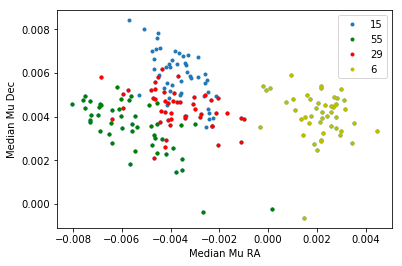

In [275]:
plt.plot(tst['MEDIAN_GALAXY_MU_RA'], tst['MEDIAN_GALAXY_MU_DEC'], '.', label = '15')
t55 = tst[np.where(tst['ZONE'] == 55)]
plt.plot(t55['MEDIAN_GALAXY_MU_RA'], t55['MEDIAN_GALAXY_MU_DEC'], 'g.', label = '55')
t29 = tst[np.where(tst['ZONE'] == 29)]
plt.plot(t29['MEDIAN_GALAXY_MU_RA'], t29['MEDIAN_GALAXY_MU_DEC'], 'r.', label = '29')
t6 = tst[np.where(tst['ZONE'] == 6)]
plt.plot(t6['MEDIAN_GALAXY_MU_RA'], t6['MEDIAN_GALAXY_MU_DEC'], 'y.', label = '6')
plt.ylabel('Median Mu Dec')
plt.xlabel('Median Mu RA')
plt.legend()
plt.show()

In [ ]:
tst2 = Median_galaxy_PMs()

/Users/Suyog/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/Suyog/anaconda/lib/python3.6/site-packages/astropy/table/column.py:954: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


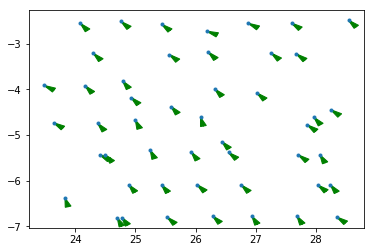

In [273]:
t29 = tst2[np.where(tst2['ZONE'] == 29)]
plt.plot(t29['RA'], t29['DEC'], '.')
for i, j in enumerate(t29):
    plt.arrow(t29['RA'][i],t29['DEC'][i],(t29['MEDIAN_GALAXY_MU_RA'][i]),(t29['MEDIAN_GALAXY_MU_DEC'][i]),
              shape='full', color='g', length_includes_head=True, 
         zorder=0, head_length=0.2, head_width=0.1)
plt.show()

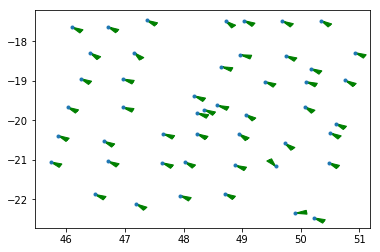

In [274]:
t55 = tst2[np.where(tst2['ZONE'] == 55)]
plt.plot(t55['RA'], t55['DEC'], '.')
for i, j in enumerate(t55):
    plt.arrow(t55['RA'][i],t55['DEC'][i],(t55['MEDIAN_GALAXY_MU_RA'][i]),(t55['MEDIAN_GALAXY_MU_DEC'][i]),
              shape='full', color='g', length_includes_head=True, 
         zorder=0, head_length=0.2, head_width=0.1)
plt.show()

In [195]:
filenames = glob('zone029/*proper_n.fits')
tiles = []
list.sort(filenames)
for name in filenames:
    tiles.append(Table.read(name))

In [207]:
d1, d2 = Galaxy_PM_tile(tiles[0])

In [208]:
print(d1)
print(d2)

-0.00634711594949
0.00391063481482
